# Business Problem

The Tanzania Development Trust is a UK charitable organization operating within the country of Tanzania since 1975.

They focus on development in rural Tanzania, aiming to support small projects in the poorest parts of the country where one of their priority areas of funding is clean water. Their stated water project involves boreholing and rope pump installation in areas with limited access to clean water, currently located in the regions of Kagera and Kigoma in the northwest of the country.

A new benefactor wants to expand the project not only geographically to more of the country, but in the scope of repairing existing pumps before they fail. I have been tasked with developing a model to predict the operating condition of a current waterpoint: functional, needs repair, or non-functional.

The main objective is to identify waterpoints that are in need of repair. [Research shows](https://sswm.info/entrepreneurship-resource/developing-impactful-businesses/maintenance-services-for-rural-water-pumps) that it is much less expensive to repair and rehabilitate a waterpoint, as well as being more protective of the water resources in the country. 
The secondary objective is to identify concentrations of non-functioning water points that may be an eligible location for a new installation.

# Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(42)

# suppress warnings if any left at end of project
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
# import training data and target
raw_data = pd.read_csv('data/training_data.csv')
raw_target = pd.read_csv('data/training_target.csv')

# create a raw dataframe combining the two on their shared feature 'id'
raw_df = pd.merge(raw_data, raw_target, on='id')

print(f"Number of datapoints: {raw_df.shape[0]}")
# subtracting 2 from column length to account for id and target columns
print(f"Numer of features: {raw_df.shape[1]-2}")

Number of datapoints: 59400
Numer of features: 39


The dataset for training includes 59,400 entries with 39 total features, a unique identifier, and a target label.
______
Lets see the distribution of our target, the functional status of the waterpoint

In [3]:
status_values = pd.DataFrame(raw_df.status_group.value_counts())
status_values.columns = ['count']
status_values['percent'] = round(raw_df.status_group.value_counts(normalize=True) * 100, 1)
status_values

,count,percent
functional,32259,54.3
non functional,22824,38.4
functional needs repair,4317,7.3


This is a ternary classification problem. The three possible values are:
- functional (F)
- non functional (NF)
- functional needs repair (FR)

Value counts show that our dataset is not balanced with respect to the label values. Only 7.3% of pumps are classified as functional needs repair, while 54.3% are functional and 38.4% are non functional. We will need to keep this imbalance in mind when modeling.
_________
We are going to change our target to numerical values, 
where:
- 'non function' will equal: 0
- 'functional needs repair' will equal: 1
- 'functional' will equal: 2

In [4]:
status_dict = {'non functional': 0,
              'functional needs repair': 1,
              'functional': 2}

raw_df['target'] = raw_df['status_group'].map(lambda x: status_dict[x])
raw_df.drop('status_group', axis=1, inplace=True)

# Null Checks

In [5]:
null_checks = pd.DataFrame(data=raw_df.isna().sum(),
                          columns=['null_count'])
null_checks['percent_of_data'] = round((null_checks.null_count / len(raw_data)) * 100, 1)
null_checks = null_checks[null_checks.percent_of_data > 0.1]
null_checks.sort_values('percent_of_data', ascending=False, inplace=True)
null_checks

,null_count,percent_of_data
scheme_name,28166,47.4
scheme_management,3877,6.5
installer,3655,6.2
funder,3635,6.1
public_meeting,3334,5.6
permit,3056,5.1
subvillage,371,0.6


There are 7 features with null values in our dataset, and we can see what that number of nulls is by percent of total available data. 
______
All of the features that contain null values are object types. We will explore them to determine how best to handle the null values.

## subvillage

In [6]:
subvillage_nans = raw_df[raw_df.subvillage.isnull()]
round(subvillage_nans.target.value_counts(normalize=True) * 100, 2)

2    55.26
0    44.47
1     0.27
Name: target, dtype: float64

The null values in subvillage represent 0.6% of our total data. The distribution of the target label is close to the whole dataset

In [7]:
subvillage_nans.region.value_counts()

Dodoma    361
Mwanza     10
Name: region, dtype: int64

In [8]:
raw_df.subvillage.value_counts()

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
               ... 
Kipompo           1
Chanyamilima      1
Ikalime           1
Kemagaka          1
Kikatanyemba      1
Name: subvillage, Length: 19287, dtype: int64

All but 10 of our subvillage nan's come from the region of Dodoma, the rest from Mwanza. More importantly, there are over 19,000 unique values for this feature, making it unlikely to use for modeling anyway as we have other geographical features. We will look at the feature more closely during categorical exploration, but for now we change null values to 'Other'

In [9]:
raw_df['subvillage'].fillna(value='Other', inplace=True)

## permit

In [10]:
permit_nans = raw_df[raw_df.permit.isnull()]
permit_nans.reset_index(drop=True, inplace=True)
round(permit_nans.target.value_counts(normalize=True) * 100, 2)

2    54.74
0    35.44
1     9.82
Name: target, dtype: float64

5% of our dataset have no value for permit. Distribution of the target label is approximately the same as the whole dataset. Per the data documentation, the permit feature is if the water point is permitted or not. We do not want to drop the feature, and the null values represent more than 5% of our data so we need to fix them. The solution we employ is to fill these 3056 missing datapoints with true/false in the same ratio we found in our entire dataset.

In [11]:
# get the distribution of permit values we do have
permit_distribution = raw_df.permit.value_counts(normalize=True)

# fill nulls with random choice of true/false in the same distribution
raw_df['permit'] = raw_df['permit'].fillna(pd.Series(np.random.choice([True, False],
                                                       p=list(permit_distribution),
                                                       size=len(raw_df))))

## public_meeting

In [12]:
public_meeting_nans = raw_df[raw_df.public_meeting.isnull()]
public_meeting_nans.reset_index(drop=True, inplace=True)
round(public_meeting_nans.target.value_counts(normalize=True) * 100, 2)

2    50.33
0    44.99
1     4.68
Name: target, dtype: float64

5.6% of our dataset has no value for public_meeting. Distribution of the target label is approximately the same as the whole dataset. The feature is a boolean that represents if a public meeting was held. It may or may not be used in modeling, so we will fill the null values in the same ratio we find with the values we do have.

In [13]:
meeting_distribution = raw_df.public_meeting.value_counts(normalize=True)

raw_df['public_meeting'] = raw_df['public_meeting'].fillna(
    pd.Series(np.random.choice([True, False],
                               p=list(meeting_distribution),
                               size=len(raw_df))))

## funder & installer

The features 'funder' and 'installer' have almost the same number of null values; I am curious about the overlap of nulls.

In [14]:
# dividing the number of entries with null for both features by the smaller count
len(raw_df[raw_df.funder.isnull() & raw_df.installer.isnull()]) / null_checks.null_count['funder']

0.9854195323246218

Over 98% of the null values for funder also contain null values for installer.
________
We need to explore the values of funder to see how best to handle the missing data.

In [15]:
funder_df = pd.DataFrame(round(raw_df.funder.value_counts(normalize=True, dropna=False) * 100, 2))
funder_df

,funder
Government Of Tanzania,15.29
NaN,6.12
Danida,5.24
Hesawa,3.71
Rwssp,2.31
...,...
Rarymond Ekura,0.00
Justine Marwa,0.00
Municipal Council,0.00
Afdp,0.00


In [16]:
funder_df_top = funder_df[funder_df.funder > 1.0]
print(f"Funders with more than 1% share: {len(funder_df_top)}")
print(f"Percent of total funders represented by above: {funder_df_top.sum()}")

Funders with more than 1% share: 18
Percent of total funders represented by above: funder    52.69
dtype: float64


Including null values, there were 1,898 distinct values for funder. Of that, 18 values (including null) have representative counts more than 1% of total data.
Those 18 distinct values represent almost 53% of our total data. We will convert null values to 'Other'. There are still lots of unique values, so something to consider is converting all funders with less than 1% total share as 'Other' to reduce the unique value count, if we even plan to use the feature at all.
____________
Lets look at installer

In [17]:
installer_df = pd.DataFrame(round(raw_df.installer.value_counts(normalize=True, dropna=False) * 100, 2))

installer_df_top = installer_df[installer_df.installer > 1.0]
print(f"Installers with more than 1% share: {len(installer_df_top)}")
print(f"Percent of total installers represented by above: {installer_df_top.sum()}")

Installers with more than 1% share: 12
Percent of total installers represented by above: installer    51.6
dtype: float64


Similarly to funder, the installer feature is dominated by small share installers. Of the 2,146 distinct values for installer, 12 values (including null) have representative counts more than 1% of total data.Those 12 distinct values represent almost 52% of our total data. 

This is similar to the funder feature. We will also convert null values to 'Other', and will consider converting all installers with less than 1% total share of installer as 'Other' to reduce the unique value count. 

In [18]:
raw_df['funder'].fillna(value='Other', inplace=True)
raw_df['installer'].fillna(value='Other', inplace=True)

## scheme_management

In [19]:
scheme_management_nans = raw_df[raw_df.scheme_management.isnull()]
scheme_management_nans.reset_index(drop=True, inplace=True)
round(scheme_management_nans.target.value_counts(normalize=True) * 100, 2)

2    48.31
0    45.94
1     5.75
Name: target, dtype: float64

In [20]:
round(raw_df.scheme_management.value_counts(normalize=True, dropna=False)*100,2)

VWC                 61.94
WUG                  8.76
NaN                  6.53
Water authority      5.31
WUA                  4.85
Water Board          4.63
Parastatal           2.83
Private operator     1.79
Company              1.79
Other                1.29
SWC                  0.16
Trust                0.12
None                 0.00
Name: scheme_management, dtype: float64

6.5% of our data has no value for scheme_management. Distribution of the target data is approximately the same as the whole dataset.

There was only one entry with the value of 'None', we will change that to 'Other'

We will fill null values for scheme_management randomly with other values from the feature in the same ratio as we did in other cases.

In [21]:
# set the 'None' to 'Other'
raw_df.at[23603, 'scheme_management'] = 'Other'

# get value counts to preserve ratio of values
scheme_management_list = pd.DataFrame(raw_df.scheme_management.value_counts(normalize=True))

# fill nulls with values in the same ratio as the data we do have
raw_df['scheme_management'] = raw_df['scheme_management'].fillna(
    pd.Series(np.random.choice(list(scheme_management_list.index),
                               p=list(scheme_management_list.scheme_management),
                               size=len(raw_df))))

## scheme_name

In [22]:
raw_df.scheme_name.value_counts(normalize=True, dropna=False)

NaN                        0.474175
K                          0.011481
None                       0.010842
Borehole                   0.009192
Chalinze wate              0.006818
                             ...   
Visiga water supplly       0.000017
Emanyata pipelines         0.000017
Magundi water supply       0.000017
Imalampaka water supply    0.000017
Mtawanya                   0.000017
Name: scheme_name, Length: 2697, dtype: float64

Almost half (47%) of the scheme_name feature contains no data, and the remaining data contains 2,697 distinct other features, none of which exceed 1% of the dataset. The scheme name, per the documentation, is the individual or group that actually operates the waterpoint. This is compared to the scheme management company, which oversees operation. When the data was collected, it looks like there was little organization with respect to this particular datapoint. Considering the large number of unique values, and that we have the management data, we will likely not use this feature in modeling. We will replace the null values with 'Other'

In [23]:
raw_df['scheme_name'].fillna(value='Other', inplace=True)

# Exploring numerical data

In [24]:
num_df = raw_df.select_dtypes(include=np.number).copy()
num_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,1.158838
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.949794
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,2.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,2.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2.000000


The 'id' feature is a unique identifier, we will leave it in for merge purposes later but will not use it in modeling so no investigation needed.

## amount_tsh

The data description states that this is the total amount of water available to the waterpoint.
_____
From the describe report above it looks like at least 50% of our waterpoints do not have any water available, regardless of pump functionality. If we look back, we also see that over 50% of pumps are classified as functional. This is a bit concerning, it's unclear how you can have a functional pump with no water available to pump.

In [25]:
len(num_df[num_df.amount_tsh == 0.0]) / len(num_df)

0.700993265993266

70% of our datapoints list the amount_tsh as equal to 0.0. This can't mean that the waterpoint has no water available. We need to understand more about what total static head means. [Research shows](https://www.pumpfundamentals.com/tutorial2.htm#:~:text=If%20the%20liquid%20surface%20of,the%20friction%20in%20the%20system.) that a pump system's static head is the difference between the liquid surface of the reservoir and the discharge end of the pump system. The higher the discharge tube is lifted above the liquid surface, the harder is is for the pump to move the water, and the lower the flow rate will be. I would imagine that the requirements of pump location to discharge would impact the type of pump to be used.

In [26]:
tsh_target = pd.DataFrame(round(num_df[num_df.amount_tsh == 0].target.value_counts(normalize=True)*100,2))
tsh_target.columns = ['tsh==0']
tsh_target['tsh>0'] = round(num_df[num_df.amount_tsh > 0].target.value_counts(normalize=True)*100,2)
tsh_target

,tsh==0,tsh>0
2,47.33,70.68
0,45.35,22.18
1,7.32,7.14


In [27]:
num_df[num_df.amount_tsh > 0].amount_tsh.describe()

count     17761.000000
mean       1062.351942
std        5409.344940
min           0.200000
25%          50.000000
50%         250.000000
75%        1000.000000
max      350000.000000
Name: amount_tsh, dtype: float64

This feature seems to be a candidate for engineering. Since 70% of our values for total static head are 0, it means most wells feature output at the same level as the water input. Only 30% of wells feature a static head larger than 0, but 70% of those wells are functional versus 47% of those with a static head of 0. We may find success modeling with it staying as a numerical feature, but we'll also engineer it into a binary feature where the value is 1 if the total static head is greater than 0.

In [28]:
# helper function to determine output value for population size
def tsh_encode(row):
    tsh = row['amount_tsh']
    
    if tsh == 0:
        return 0
    else:
        return 1
    
# create new feature 'age' with the helper function
num_df['positive_tsh'] = num_df.apply(tsh_encode, axis=1)

## gps_height

The data description states that this is the altitude of the well
_____________
[Research shows](https://en.wikipedia.org/wiki/Geography_of_Tanzania) that the lowest point in the country is sea level (0), yet we have a minimum of -90, so we will need to investigate that.

In [29]:
gps_height_neg = num_df[num_df.gps_height < 0]
print(f"Percent of total data: {round(len(gps_height_neg)/len(num_df)*100,2)}%")
gps_height_neg.describe()

Percent of total data: 2.52%


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target,positive_tsh
count,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000
mean,37297.606952,313.013369,-19.993316,39.352801,-7.727535,0.506684,34.703877,15.531417,258.137032,1686.096257,1.073529,0.431818
std,21119.500129,4017.641868,12.154136,0.458811,1.542230,7.155227,35.259116,21.812220,428.417873,726.379806,0.983446,0.495495
min,150.000000,0.000000,-90.000000,38.614960,-10.946096,0.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,19232.750000,0.000000,-28.000000,38.972421,-8.584131,0.000000,6.000000,1.000000,40.000000,1976.000000,0.000000,0.000000
50%,36699.000000,0.000000,-18.000000,39.281546,-7.415977,0.000000,7.000000,5.000000,102.500000,2000.000000,2.000000,0.000000
75%,55492.750000,50.000000,-11.000000,39.662349,-6.524902,0.000000,60.000000,13.000000,320.000000,2008.000000,2.000000,1.000000
max,74211.000000,138000.000000,-1.000000,40.345193,-5.278598,150.000000,99.000000,67.000000,4520.000000,2013.000000,2.000000,1.000000


There are 1,496 data points where the gps_height was less than 0, about 2.5% of our data. Earlier we mentioned that this should not be possible as the listed lowest elevation for Tanzania is 0 ft above sea level (at the Indian Ocean). [Research shows](https://eos-gnss.com/knowledge-base/articles/elevation-for-beginners) that most GPS units are designed to measure height based on the representation of the earth's surface as an 'ellipsoid', and it's perfectly possible to be standing at sea level where the reading should be 0 and have it be a negative number. 

Considering these data are almost all on the southeastern edge of the country (higher longitudes, lower latitudes) closer to the Indian Ocean, it is likely the sites are at or just above sea level and capable of producing negative height readings. Opportunity for further tuning could be to address this inconsistency across all the data, shifting all data points to a more accurate representation of height. I do not think it would be as simple as shifting all values up by the largest negative difference. Because it's such a small percentage of our dataset, we will just set them to 0 rather than worry about adjusting all the values.

In [30]:
num_df.gps_height.clip(lower=0.0, inplace=True)

## longitude/latitude

The data description states that these are the GPS coordinates.
______
[Research shows](https://worldpopulationreview.com/countries/tanzania/location) that Tanzania's most extreme latitudes range from 00&deg;59'S (-0.98333) to 11&deg;45'S (-11.75), while the longitude extremes range from 40&deg;29'E (40.48333) to 29&deg;10'E (29.16667)

The 'latitude' values seem to exceed the northen border of the country (max latitude -2e-08), so we will need to investigate that. The 'longitude' values minimum is 0, so we have some data that is outside the range of the country borders. It's likely from mistakes or errors in data entry, so we need to examine all values below the actual minimum which is 29.16667.

In [31]:
longitude_errors = num_df[num_df.longitude < 29.16667]
longitude_errors.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target,positive_tsh
count,1812.000000,1812.0,1812.0,1812.0,1.812000e+03,1812.0,1812.000000,1812.000000,1812.0,1812.0,1812.000000,1812.0
mean,37389.841060,0.0,0.0,0.0,-2.000000e-08,0.0,17.820088,2.497241,0.0,0.0,1.173289,0.0
std,21413.129962,0.0,0.0,0.0,3.309636e-24,0.0,1.023562,2.157389,0.0,0.0,0.870267,0.0
min,15.000000,0.0,0.0,0.0,-2.000000e-08,0.0,11.000000,1.000000,0.0,0.0,0.000000,0.0
25%,18481.750000,0.0,0.0,0.0,-2.000000e-08,0.0,17.000000,1.000000,0.0,0.0,0.000000,0.0
50%,37326.000000,0.0,0.0,0.0,-2.000000e-08,0.0,17.000000,1.000000,0.0,0.0,1.000000,0.0
75%,55509.750000,0.0,0.0,0.0,-2.000000e-08,0.0,19.000000,6.000000,0.0,0.0,2.000000,0.0
max,74193.000000,0.0,0.0,0.0,-2.000000e-08,0.0,19.000000,6.000000,0.0,0.0,2.000000,0.0


It looks like we have found that our data includes errors in GPS readings. These errors show up as longitude 0 and latitude -2e-0.8. These entries with GPS errors, however, do not account for all the population point values of 0, or the construction year values of 0, so we will still need to address them.

In [32]:
print(f"Percent of data with missing lat/long: {round((len(longitude_errors)/len(num_df))*100, 2)}%")
print(f"Total data with population of 0: {len(num_df[num_df.population == 0])}")
print(f"Total data with construction year of 0: {len(num_df[num_df.construction_year == 0])}")

Percent of data with missing lat/long: 3.05%
Total data with population of 0: 21381
Total data with construction year of 0: 20709


In [33]:
gps_errors = raw_df[raw_df.longitude == 0.0]
gps_errors.target.value_counts(normalize=True)

2    0.480132
0    0.306843
1    0.213024
Name: target, dtype: float64

In [34]:
gps_errors.region_code.value_counts()

17    1057
19     752
11       3
Name: region_code, dtype: int64

The missing GPS data comprises about 3% of our dataset, but contains a disproportionate number of the 'functional needs repair' value from the target, which we already have very little data for. Also, all of the missing GPS data comes from three regions: 11, 17, and 19. 

What we can do is take the average lat/long from the points we do have for those region_codes and fill our nulls with the average for that region_code with a little randomness added in within a range of + or - one standard deviation from the mean.

In [35]:
# get the list of the region codes with errors
error_regions = list(gps_errors.region_code.value_counts().index)

for region in error_regions:
    # split the region based on longitude not being 0.0
    region_no_gps = num_df[(num_df.region_code == region) & (num_df.longitude == 0.0)].copy()
    region_gps_data = num_df[(num_df.region_code == region) & (num_df.longitude != 0.0)].copy()
    # get mean and std for the long/lat of gps data we have
    avg_long = region_gps_data[['longitude', 'latitude']].mean()[0]
    avg_lat = region_gps_data[['longitude', 'latitude']].mean()[1]
    long_std = region_gps_data[['longitude', 'latitude']].std()[0]
    lat_std = region_gps_data[['longitude', 'latitude']].std()[1]
    # initialize empty lists for random data to fill
    fill_long = []
    fill_lat = []
    # append to each list a random value within the standard deviation of the mean
    for x in range(len(region_no_gps)):
        fill_long.append(random.triangular(avg_long+long_std, avg_long-long_std))
        fill_lat.append(random.triangular(avg_lat+lat_std, avg_lat-lat_std))
        x += 1
    # convert the two lists into a dataframe
    fill_df = pd.DataFrame([fill_long, fill_lat]).transpose()
    # sets the column names and indeces to match the ones being replaced
    fill_df.columns = ['longitude', 'latitude']
    fill_df.index = region_no_gps.index
    # replace the missing GPS data with these randomized values
    num_df.loc[region_no_gps.index, ['longitude', 'latitude']] = fill_df

## num_private

The data description for this feature does not exist.

In [36]:
round(num_df.num_private.value_counts(normalize=True)*100, 2)

0       98.73
6        0.14
1        0.12
5        0.08
8        0.08
        ...  
42       0.00
23       0.00
136      0.00
698      0.00
1402     0.00
Name: num_private, Length: 65, dtype: float64

The vast majority (98.73%) of the num_private data has the value 0. There was no descriptor of the feature along with the others for the dataset, so we have no way to reference the value. A guess would be the number of private wells at the waterpoint, or perhaps the number of private users of a waterpoint. Either way, with such a massive value imbalance it's very unlikely that there would be any statistically significant relationship between this feature and the target. We are going to drop it from num_df and consideration in modeling.

In [37]:
num_df.drop('num_private', axis=1, inplace=True)

## region_code

The data description for this is geographic location.
__________
[Research shows](https://en.wikipedia.org/wiki/Subdivisions_of_Tanzania) that what we initially suspected is true: regions are the parent of districts. There are 31 regions, 169 districts, and then further divisions of wards (urban or rural), streets under urban wards, and villages and hamlets under rural wards. We know we have features for subvillage and ward, and will get to them later. For now, since we have codes for region and strings for regions, lets compare them and see what we can discover.

**NOTE: we are exploring numerical data for region_code, but cross-referencing the 'region' values from the raw_df**

In [38]:
print(f"Region numeric unique value count: {len(num_df.region_code.value_counts())}")
print(f"Region string unique value count: {len(raw_df.region.value_counts())}")
print("------------------------------------")
region_code_vals = list(map(str, list(num_df.region_code.value_counts().sort_index().index)))
print("Region_code values:")
print(", ".join(region_code_vals))
print("------------------------------------")
high_region_codes = raw_df[(num_df.region_code > 21)].copy()
print(f"Entries with region code > 21: {len(high_region_codes)}")
print(f"Percent of total data: {round(len(high_region_codes)/len(raw_df)*100, 2)}%")
print("------------------------------------")

Region numeric unique value count: 27
Region string unique value count: 21
------------------------------------
Region_code values:
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 40, 60, 80, 90, 99
------------------------------------
Entries with region code > 21: 3930
Percent of total data: 6.62%
------------------------------------


In [39]:
len(raw_df[(raw_df.region_code > 21)]) == len(raw_df[(raw_df.region_code > 21) & (raw_df.longitude != 0.0)])

True

We can see that the values of region_code go from 1 to 21, and then we have values 24, 40, 60, 80, 90, 99. It's likely that the values 1-21 match up to the 21 string value regions in the feature 'region'.

Entries with region_code values above 21 constitute 6.6% of our dataset, and all of the data categorized in these other region_codes contain correct lat/long data. (note: checked this using the raw_df, not the num_df we modified the missing lat/longs for)

As for the others, they serve some kind of purpose inputting data. We will need to figure out:
- What region_code matches to what region?
- What do the >21 region_code values mean?
_________

### matching region and region_code

We are going to create a dataframe that goes through the region_codes 1-21 and adds the top reporting region/count from the value_count for that particular region_code. Then we look at any differences between those counts and the raw counts of entries with each region code.

In [40]:
region_code_list = []

for x in range(1, 22):
    region = raw_df[raw_df.region_code == x]['region'].value_counts().index[0]
    count = raw_df[raw_df.region_code == x]['region'].value_counts().values[0]
    region_code_list.append((x, region, count))
    
region_df = pd.DataFrame(region_code_list, columns=['region_code', 'region', 'region_count'])
region_df['region_code_count'] = raw_df.region_code.value_counts().sort_index().values[:21]

region_df['surplus_code_count'] = region_df['region_code_count'] - region_df['region_count']
region_df[region_df.surplus_code_count > 0]

,region_code,region,region_count,region_code_count,surplus_code_count
4,5,Morogoro,4006,4040,34
10,11,Iringa,5294,5300,6
13,14,Tabora,1959,1979,20
16,17,Shinyanga,4956,5011,55
17,18,Kagera,3316,3324,8


Of the 21 regions, 16 of them match up the region with a region_code and both features have the same count of values. There are 5 regions where the region_code value count has a surplus of values compared to the region value count.

For these few number of values, one thought is to update records for these region_codes so that all region_code values match to one region, i.e. we will update all rows where region_code is 5 so that the region 'Morogoro' is reflected. Just to be sure, lets look closer at this example.


In [41]:
raw_df[raw_df.region_code == 5].region.value_counts()

Morogoro    4006
Tanga         34
Name: region, dtype: int64

In [42]:
raw_df[(raw_df.region_code == 5) & (raw_df.region == 'Tanga')][['longitude', 'latitude']].mean()

longitude    37.180390
latitude     -6.039227
dtype: float64

When we looked at the mean lat/longs for the region_code 5 rows that have the region label 'Tanga', it is  within the boundary of the region 'Morogoro', near the northrn border with Tanga. We are going to make an assumption that these values of region_code reference the same region string, and assume that is also the case for the remaining surpluses. We will update those region values accordingly so that each region_code corresponds to one and only one region string. **Note: we are modifying the original raw_df here. We will then split off all categorical features in a later section to encode. The 'region' feature is not a part of num_df**

In [43]:
fixes = list(zip(list(region_df[region_df.surplus_code_count > 0].region_code.values),
    list(region_df[region_df.surplus_code_count > 0].region.values)))

for fix in fixes:
    code = fix[0]
    region = fix[1]
    
    raw_df.loc[raw_df[(raw_df.region_code == code) & (raw_df.region != region)].index, 'region'] = region

________________

### region_codes over 21

Now we need to examine the region_codes whose value is over 21 and figure out what they mean.

In [44]:
num_df[num_df.region_code > 21].region_code.value_counts()

80    1238
60    1025
90     917
99     423
24     326
40       1
Name: region_code, dtype: int64

We have about 6.6% of our data in these incorrectly labeled region_codes. We have just modified our raw_df dataframe and assigned all entries' region values based on the (top) region_code value count. Lets look at our data grouped by region value and see the average for the region_code. If the average is an integer, we know that all entries for that region is the same number as the entries for the region_code (that value being the mean of the region_code feature). If it's not an integer, then it means that the region is represented by different region_codes and we can figure out which codes and reassign them correctly.

In [45]:
region_codes = raw_df.groupby('region')[['region_code']].mean().sort_values(by='region_code')
region_codes['is_int'] = region_codes.region_code.apply(lambda x: x.is_integer())
region_codes = region_codes[region_codes.is_int == False]
region_codes

,region_code,is_int
region,,
Arusha,4.140896,False
Pwani,27.018596,False
Lindi,65.955787,False
Mtwara,73.940462,False


We can see that these four regions are the ones without integer value region_code averages. We can deduce that all of the region_code values over 21 are attributed to these 4 regions. Now we will go through each region_code attributed to these regions and look at the lat/long averages. If they are in the same region, the averages should be fairly close in value.

In [46]:
# get the list of regions from above
regions = list(region_codes.index)

region_checks = []

# for each region, generate a row of data containing the region
for region in regions:
    codes = list(raw_df[raw_df.region == region].region_code.value_counts().index)
    for code in codes:
        long_avg = raw_df[raw_df.region_code == code][['longitude']].describe().loc[['mean']].longitude.values[0]
        lat_avg = raw_df[raw_df.region_code == code][['latitude']].describe().loc[['mean']].latitude.values[0]
        row = [region, code, long_avg, lat_avg]
        region_checks.append(row)

region_check_df = pd.DataFrame(region_checks,
                              columns = ['region','code','long_avg','lat_avg'])
region_check_df

,region,code,long_avg,lat_avg
0,Arusha,2,36.648738,-3.231963
1,Arusha,24,35.661985,-3.380886
2,Pwani,6,38.754707,-6.678934
3,Pwani,60,39.073593,-7.529581
4,Pwani,40,39.217993,-7.001266
5,Lindi,80,39.094711,-9.645071
6,Lindi,8,38.572954,-10.310537
7,Mtwara,90,38.958680,-10.805449
8,Mtwara,99,40.004465,-10.457718
9,Mtwara,9,39.771740,-10.628146


Right away we can see close value counts for these groupings of regions; we cross-referenced these lat/long averages using Google maps to confirm region. Each of these 4 regions had several region codes, and we will consolidate the region_code value to the lowest one. We will reassign them in both the num_df dataframe and the raw_df dataframe.

In [47]:
# all Arusha region codes should be 2
num_df.loc[raw_df[raw_df.region_code == 24].index, 'region_code'] = 2
raw_df.loc[raw_df[raw_df.region_code == 24].index, 'region_code'] = 2

# all Pwani region codes should be 6
num_df.loc[raw_df[raw_df.region_code.isin([40, 60])].index, 'region_code'] = 6
raw_df.loc[raw_df[raw_df.region_code.isin([40, 60])].index, 'region_code'] = 6

# all Lindi region codes should be 8
num_df.loc[raw_df[raw_df.region_code == 80].index, 'region_code'] = 8
raw_df.loc[raw_df[raw_df.region_code == 80].index, 'region_code'] = 8

# all Mtwara regions should be code 9
num_df.loc[raw_df[raw_df.region_code.isin([90, 99])].index, 'region_code'] = 9
raw_df.loc[raw_df[raw_df.region_code.isin([90, 99])].index, 'region_code'] = 9

## district_code

The data description for this is geographic location.

In [48]:
regions_with_codes = pd.DataFrame(raw_df.groupby('region').mean()['region_code'])
regions_with_codes.reset_index(inplace=True)
regions_with_codes['region_code'] = regions_with_codes.region_code.astype('int')
regions_with_codes.set_index('region_code', inplace=True)
regions_with_codes.sort_index(inplace=True)
regions_with_codes

,region
region_code,
1,Dodoma
2,Arusha
3,Kilimanjaro
4,Tanga
5,Morogoro
6,Pwani
7,Dar es Salaam
8,Lindi
9,Mtwara


We have established that the regions in our dataset match up with the region_code; there is no 'district' dataset to match with 'district_code'. When researching Tanzanian regions we discovered information on quantity of districts  in each region, so we believe that is how our data relates: each region would have multiple districts in it. Lets look at value counts for district_code.

In [49]:
num_df.district_code.value_counts().sort_index()

0        23
1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
13      391
23      293
30      995
33      874
43      505
53      745
60       63
62      109
63      195
67        6
80       12
Name: district_code, dtype: int64

Some initial observations:
- It seems odd to have districts with a value of 0.
- [Research shows](https://en.wikipedia.org/wiki/Regions_of_Tanzania) that there is one region with 10 districts (Tanga), but we don't have that value. 
- 10 is is also the largest value we should have for the feature, as that is the maximum number of districts for regions.

_____
If it is the case that district_code is representative of the actual district within the region, then each region should have at minimum a district_code of 1. The link above will also show that regions at a minimum have 2 districts (the average is about 5.5). Lets go through and see if each region even has the correct number of districts per our research.

In [50]:
district_info = []

for x in range(1, 22):
    # get our region name
    region = regions_with_codes[regions_with_codes.index == x].region.values[0]
    # use the num_df to list all the district codes with that region_code
    districts = sorted(list(num_df[num_df.region_code == x].district_code.value_counts().index))
    # create the row of data
    row = [region, len(districts), districts]
    # append to list
    district_info.append(row)

district_info_df = pd.DataFrame(district_info,
                               columns=['region','district_count', 'district_values'])
district_info_df.sort_values(by='region', inplace=True)
# input expected district count from research (based on alphabetical order of region in our data)
district_info_df['expected_district_count'] = [7, 5, 7, 5, 8, 8, 6, 6, 6, 7, 7, 7, 7, 7, 7, 4, 6, 5, 6, 7, 10]
district_info_df['district_count_discrepancy'] = district_info_df.district_count - district_info_df.expected_district_count
district_info_df

,region,district_count,district_values,expected_district_count,district_count_discrepancy
1,Arusha,7,"[1, 2, 3, 5, 6, 7, 30]",7,0
6,Dar es Salaam,3,"[1, 2, 3]",5,-2
0,Dodoma,6,"[0, 1, 3, 4, 5, 6]",7,-1
10,Iringa,6,"[1, 2, 3, 4, 5, 7]",5,1
17,Kagera,8,"[1, 2, 3, 4, 6, 7, 8, 30]",8,0
15,Kigoma,4,"[1, 2, 3, 4]",8,-4
2,Kilimanjaro,7,"[1, 2, 3, 4, 5, 6, 7]",6,1
7,Lindi,6,"[3, 13, 23, 43, 53, 62]",6,0
20,Manyara,5,"[1, 2, 3, 4, 5]",6,-1
19,Mara,5,"[1, 2, 3, 4, 6]",7,-2


In [51]:
district_info_df.district_count.sum()

129

In [52]:
district_info_df.district_count_discrepancy.sum()

-9

Observations:
- Even the largest count value, district_code of 1, is not represented in all of our regions, which should be the case if each region had a separate count of districts.
- Even if we had the correct number of districts, they were not necessarily numbered in the correct way. Arusha should have 7 districts, and we would expect 1-7 but we have no district_code 4 (instead, we have a 30)
- Some regions have more than the expected number of districts, some have less. If we simply had mislabeled districts, then our sum of discrepancies should be equal, but it is not, we are 9 total districts heavy of what we should have.

It's suspected that there will not be an easy way to reconcile this feature. If we were able to organize this, we would also then need to have unique values for each district among all regions to give it any meaningful impact. It's likely the case that we will not be using district_code in modeling.

In [53]:
num_df.drop('district_code', axis=1, inplace=True)

## population

The data description for this is population around the well.

In [54]:
num_df['population'].describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [55]:
num_df.population.value_counts(normalize=True)[0]

0.35994949494949496

In [56]:
num_df.population.value_counts(sort=False, bins=15)

(-30.501, 2033.333]       58922
(2033.333, 4066.667]        325
(4066.667, 6100.0]           85
(6100.0, 8133.333]           53
(8133.333, 10166.667]        12
(10166.667, 12200.0]          1
(12200.0, 14233.333]          0
(14233.333, 16266.667]        1
(16266.667, 18300.0]          0
(18300.0, 20333.333]          0
(20333.333, 22366.667]        0
(22366.667, 24400.0]          0
(24400.0, 26433.333]          0
(26433.333, 28466.667]        0
(28466.667, 30500.0]          1
Name: population, dtype: int64

Just about 36% of our population data is 0, 50% is 25 or under, and 75% is 215 or under. The average population is 180.

When we look at the population auto-binned into 15 bins of equal value width, you can see that the vast majority are under 2000, and also that once we are over about 10,000 people there are only 3 datapoints, with large gaps in between. Lets look at counts with the population at 0, counts where 0 < population <= 180 (our average) and then more than 180.

In [57]:
print(f"   [0.0,0.0]    {len(num_df[num_df.population == 0.0])}")
print(f"(0.0, 180.0]    {len(num_df[(num_df.population <= 180) & (num_df.population > 0)])}")
print(f"   (180.0, ]    {len(num_df[num_df.population > 180])}")

   [0.0,0.0]    21381
(0.0, 180.0]    20633
   (180.0, ]    17386


Not quite but almost even separation of these bins. This is one way we may be able to engineer population if necessary.
_______
Lets look at binning the values into 10 bins between 0 and 180 just to get an idea of distribution within that range.

In [58]:
num_df[(num_df.population <= 180) & (num_df.population > 0)].population.value_counts(normalize=True, sort=False, bins=10)

(0.82, 18.9]      0.369021
(18.9, 36.8]      0.085882
(36.8, 54.7]      0.102796
(54.7, 72.6]      0.074929
(72.6, 90.5]      0.070033
(90.5, 108.4]     0.074008
(108.4, 126.3]    0.062230
(126.3, 144.2]    0.030340
(144.2, 162.1]    0.110987
(162.1, 180.0]    0.019774
Name: population, dtype: float64

Most of these population values are under 19, but that only represents a bit more than a third of the total bin (36.9%). The other bins are between 2 and 11 percent.
__________________
Lets explore binning the populations over 180

In [59]:
num_df[(num_df.population > 180) & (num_df.population > 0)].population.value_counts(sort=False, bins=100)

(150.68, 484.19]        11683
(484.19, 787.38]         3294
(787.38, 1090.57]        1064
(1090.57, 1393.76]        331
(1393.76, 1696.95]        323
                        ...  
(28984.05, 29287.24]        0
(29287.24, 29590.43]        0
(29590.43, 29893.62]        0
(29893.62, 30196.81]        0
(30196.81, 30500.0]         1
Name: population, Length: 100, dtype: int64

After playing around increasing our bin size all the way up to 100, we could really get a feel that most of these population values were still under 500.

I suspect the best way to include population is not to have it remain numerical, but to convert to a categorical feature. My idea is to bin into these three categories: 0 population, population between 0 and 180, and populations above 180.

In [60]:
# helper function to determine output value for population size
def pop_encode(row):
    pop = row['population']
    
    if pop == 0:
        return 0
    elif (pop > 0) & (pop <= 180):
        return 1
    else:
        return 2
    
# create new feature 'age' with the helper function
num_df['pop_encoded'] = num_df.apply(pop_encode, axis=1)

## construction_year

In [61]:
num_df['construction_year'].describe()

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [62]:
const_year_0_df = num_df[num_df.construction_year == 0.0].copy()
const_year_df = num_df[num_df.construction_year != 0.0].copy()

print(f"Count of values with construction year of 0: {len(const_year_0_df)}")
print(f"Count of values with a construction year: {len(const_year_df)}")
print("-------------------------------------------")
print(f"Percentage of values with no contruction year: {round(len(const_year_0_df)/len(num_df)*100, 2)}%")

Count of values with construction year of 0: 20709
Count of values with a construction year: 38691
-------------------------------------------
Percentage of values with no contruction year: 34.86%


In [63]:
const_year_df.construction_year.describe()

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

In [64]:
const_year_df.construction_year.mode()

0    2010
dtype: int64

A little more than a third (34.9%) of our data contains no construction year. Of the data we do have for construction year, it ranges from 1960 to 2013, with an average year of 1996 and a mode of 2010.
__________


Initial idea was to use the date_recorded feature to calculate an age for the pump. We could then bin that, including a bin for 'unknown'.

In [65]:
# add the date_recorded feature to our numerical dataframe
num_df['date_recorded'] = pd.to_datetime(raw_df.date_recorded)

# extract the year from date_recorded into a separate feature
num_df['year'] = num_df['date_recorded'].map(lambda x: x.year)

# helper function to calculate age if we have a construction year
def calc_age(row):
    if row['construction_year'] == 0:
        return 99
    else:
        return int(row['year'] - row['construction_year'])
    
# create new feature 'age' with the helper function
num_df['age'] = num_df.apply(calc_age, axis=1)

In [66]:
num_df[num_df.age < 99].age.value_counts(normalize=True)

 3     0.070818
 1     0.059523
 2     0.055026
 5     0.051175
 4     0.048849
 13    0.048306
 7     0.036288
 6     0.035693
 11    0.034944
 14    0.029981
 8     0.029981
 33    0.028947
 15    0.025665
 23    0.023390
 10    0.022434
 16    0.021349
 9     0.021038
 19    0.019798
 27    0.019695
 18    0.019488
 28    0.018325
 31    0.018325
 35    0.016722
 17    0.016438
 39    0.015533
 37    0.015507
 26    0.015223
 0     0.015197
 25    0.015068
 21    0.014939
 29    0.014577
 12    0.014448
 20    0.013983
 41    0.012613
 30    0.009279
 43    0.009201
 38    0.009072
 36    0.008400
 22    0.008348
 24    0.006746
 40    0.006022
 34    0.004756
 32    0.004497
 53    0.002352
 42    0.002326
 50    0.002171
 45    0.001706
 46    0.001241
 44    0.001215
 48    0.001060
 51    0.000801
 49    0.000646
 47    0.000362
 52    0.000284
-5     0.000078
-4     0.000052
-2     0.000026
-7     0.000026
-1     0.000026
-3     0.000026
Name: age, dtype: float64

Initial observations:
- The most frequent age is 3 years, at 7%. 7 of the 10 most frequent values for age are under 10.
- We have some negative values, which should not be possible as you can't sample a waterpoint that hasn't been constructed yet. Need to check on this.

In [67]:
num_df.year.value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: year, dtype: int64

In [68]:
num_df[num_df.year > 2005].date_recorded.mean()

Timestamp('2012-03-30 20:23:54.688136960')

It looks like our date_recorded feature has some errors in it.  We have one entry with a year of 2002, and 30 in 2004. The majority of our data was collected in 2011, 2012, and 2013. The average date for the data (not including these 31 date_recorded outliers) is the end of March 2012. If we look at the distribution of the years this looks accurate. Lets look a little closer to see how we can fix these datapoints from years before they were constructed.

In [69]:
num_df[num_df.age < 0]

,id,amount_tsh,gps_height,longitude,latitude,region_code,population,construction_year,target,positive_tsh,pop_encoded,date_recorded,year,age
8729,20198,0.0,86.0,38.959776,-5.247278,4,120,2008,0,0,1,2004-05-01,2004,-4
10441,55069,20.0,307.0,38.768656,-7.298419,6,1,2006,0,1,1,2004-12-01,2004,-2
13366,48759,100.0,1331.0,34.290885,-1.699609,20,80,2011,2,1,1,2004-06-01,2004,-7
23373,20534,50.0,239.0,39.272736,-11.019000,9,317,2009,2,1,2,2004-03-01,2004,-5
27501,53086,500.0,1611.0,34.900561,-8.873813,11,65,2009,2,1,1,2004-01-07,2004,-5
32619,9195,0.0,1856.0,31.539761,-7.983106,15,900,2005,0,0,2,2004-03-01,2004,-1
33942,5971,0.0,0.0,39.283105,-7.422852,6,200,2007,0,0,2,2004-03-01,2004,-3
39559,15921,0.0,301.0,38.558421,-5.140405,4,713,2009,0,0,2,2004-03-06,2004,-5
48555,1251,0.0,284.0,38.929212,-7.111349,6,185,2008,2,0,2,2004-12-01,2004,-4


We can see that all the errors come from datapoints reported as 'collected' in 2004. If the one 'collected' in 2002 doesn't report a negative age, then it was constructed prior to that year. Since it's only 31 datapoints, we are going to change all the years of 2004 and 2002 to 2012, the median year of observations. We then need to repeat the creation of the 'age' feature, then drop the year column from num_df

In [70]:
num_df.loc[num_df[num_df.year == 2002].index, 'year'] = 2012
num_df.loc[num_df[num_df.year == 2004].index, 'year'] = 2012

num_df['age'] = num_df.apply(calc_age, axis=1)

num_df.drop(['year'], axis=1, inplace=True)

In [71]:
num_df[num_df.age < 99].age.describe()

count    38691.000000
mean        15.359257
std         12.491646
min          0.000000
25%          5.000000
50%         13.000000
75%         25.000000
max         53.000000
Name: age, dtype: float64

In [72]:
num_df[num_df.age < 99].age.value_counts(bins=4)

(-0.054, 13.25]    21043
(13.25, 26.5]       8915
(26.5, 39.75]       7106
(39.75, 53.0]       1627
Name: age, dtype: int64

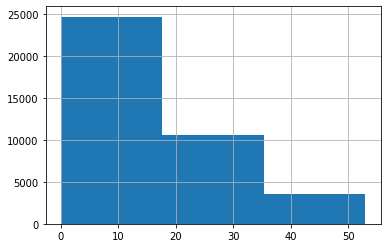

In [73]:
num_df[num_df.age < 99].age.hist(bins=3);

The idea at this point was to bin this into an encoded categorical at the quartiles, so 0-5, 5-13, 13-25, and 25-53 and then the 'dropped' category is the ones with no age.
________
That process was more elaborate and may be difficult to pipeline for production. A second idea is to not calculate age, but bin the construction year by decade while including a categorical value for no construction year. Lets implement that to to see how it looks.

In [74]:
# helper function to determine output value for construction year
def const_encode(row):
    
    # meta-helper function to get the 2nd digit from the right to determine decade
    def get_decade(number):
        return number // 10 % 10
    
    if row.construction_year == 0:
        return 'None'
    else:
        return f'{get_decade(row.construction_year)}0s'
    
# create new feature 'age' with the helper function
num_df['const_year_encoded'] = num_df.apply(const_encode, axis=1)

After exploring the categorical data we will have to encode what features we are using, and at that time we can also encode these feature.

# Mapping

In [75]:
import folium as folium

In [76]:
lat_mid = num_df.latitude.mean()
long_mid = num_df.longitude.mean()

m = folium.Map(location=[lat_mid, long_mid])

lat_longs = list(zip(num_df.latitude, num_df.longitude))
target = list(num_df.target)


In [77]:
# inspiration from https://jacobtadesse.com/2019/09/28/visualizing-pandas-dataframe-lat-long-with-folium-maps/

def add_coord(coords, m):
    """
    Creates markers for all the coordinates passed on the map
    
    Input(s):
    coords: a list of coordinates tupled as (lat, long)
    m: a folium map instatiated
    
    Output(s):
    none
    """
    markers = {}
    
    for i, loc in enumerate(coords):
        markers[i] = folium.CircleMarker(location=loc, radius=0.001)
        markers[i].add_to(m)

In [78]:
markers = add_coord(lat_longs, m)

In [79]:
# m

# Exploring categorical data

We still need the ID and target columns (for merging and investigation respectively), so we can't just wholesale select object columns from our raw_data. So we make a list of features to drop to make a dataframe of all our categorical data with those 2 numerical features.

In [80]:
num_features = ['amount_tsh', 'gps_height', 'longitude', 'latitude',
               'num_private', 'region_code', 'district_code', 'population',
               'construction_year']

cat_df = raw_df.drop(num_features, axis=1).copy()
list(cat_df.columns)

['id',
 'date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'target']

We already know that the 'id' feature is a unique numerical identifier. This will allow us to merge our cat_df with our num_df after investigative all the categorical variables. We already know that there are some features we will likely not use in modeling, such as 'date_recorded' and 'subvillage', so we will start a running drop list that will all be dropped before merging with numerical data.

In [81]:
drop_list = []

### Helper functions

In [82]:
def value_count_report(feature):
    """
    This is a helper function to report value counts for categeorical features 
    of the dataset and return a dataframe of the feature value counts for
    further investigation.
    
    Input(s):
    - 'feature' (required): string of feature to investigate
    
    Output(s):
    - 'feature_df': a DataFrame of the unique values and counts for the feature
    """
    # set up dataframe for unique values and counts. We have already dealt with
    # null values so no need to worry about including them here.
    feature_df = pd.DataFrame(cat_df[feature].value_counts())
    feature_df['percentage'] = round(cat_df[feature].value_counts(normalize=True)*100,2)
    
    # a second dataframe subset of the first where the value count is 1
    feature_df_singles = feature_df[feature_df[feature] == 1]
    
    # quick report on total unique values, how many are single, and what percent that is
    print(f"Unique values for '{feature}': {len(feature_df)}")
    print("--------------------------")
    print(f"Unique values with a single representative: {len(feature_df_singles)}")
    print(f"Percent of values that are single: {round((len(feature_df_singles)/len(feature_df)*100),2)}%")
    
    return feature_df

[Inspiration](https://blog-softhints-com.cdn.ampproject.org/v/s/blog.softhints.com/display-two-pandas-dataframes-side-by-side-jupyter-notebook/amp/?usqp=mq331AQKKAFQArABIIACAw%3D%3D&amp_js_v=a8&amp_gsa=1#referrer=https%3A%2F%2Fwww.google.com&csi=0&ampshare=https%3A%2F%2Fblog.softhints.com%2Fdisplay-two-pandas-dataframes-side-by-side-jupyter-notebook%2F) for rendering DataFrames side-by-side with a CSS override.

In [83]:
from IPython.display import display, HTML

css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

## date_recorded

The 'date_recorded' feature is likely not going to mean anything for analysis, and we have already used it to calculate ages of waterpoints. We will add this feature to our running drop list.

In [84]:
drop_list.append('date_recorded')

## funder / installer

The data description states that the funder is who funded the well and the installer is who installed it.
_____
During null checks we noticed that both of these features have a large number of unique values and weren't likely to be used for modeling, we'll look at them a bit closer just to be sure.

In [85]:
funder_df = value_count_report('funder')
print("-------------------------------------------------")
installer_df = value_count_report('installer')

Unique values for 'funder': 1898
--------------------------
Unique values with a single representative: 974
Percent of values that are single: 51.32%
-------------------------------------------------
Unique values for 'installer': 2146
--------------------------
Unique values with a single representative: 1098
Percent of values that are single: 51.16%


In [86]:
display(funder_df)
display(installer_df)

,funder,percentage
Government Of Tanzania,9084,15.29
Other,3635,6.12
Danida,3114,5.24
Hesawa,2202,3.71
Rwssp,1374,2.31
...,...,...
Rarymond Ekura,1,0.00
Justine Marwa,1,0.00
Municipal Council,1,0.00
Afdp,1,0.00


,installer,percentage
DWE,17402,29.30
Other,3655,6.15
Government,1825,3.07
RWE,1206,2.03
Commu,1060,1.78
...,...,...
Wizara ya maji,1,0.00
TWESS,1,0.00
Nasan workers,1,0.00
R,1,0.00


We have almost 1900 unique funders, just over half of which are represented just once, and a similar situation with installers.


It doesn't appear that either feature is suitable for modeling, even with engineering. There are just too many unique values to be able to consolidate. The values that do have larger representation are pretty much government or government organizations, but they still only represent a small portion of the values.

In [87]:
drop_list.extend(['funder', 'installer'])

## wpt_name

The data description states that this feature is the name of the waterpoint, if there is one

In [88]:
wptname_df = value_count_report('wpt_name')

Unique values for 'wpt_name': 37400
--------------------------
Unique values with a single representative: 32928
Percent of values that are single: 88.04%


88% of our waterpoint names are represented by a single entry. Out of curiosity, lets look at our top 20 values.

In [89]:
wptname_top20 = wptname_df[:20]
wptname_top20.reset_index(inplace=True)
wptname_top20.columns = ['wpt_name', 'count', 'percentage']
wptname_top20

,wpt_name,count,percentage
0,none,3563,6.00
1,Shuleni,1748,2.94
2,Zahanati,830,1.40
3,Msikitini,535,0.90
4,Kanisani,323,0.54
5,Bombani,271,0.46
6,Sokoni,260,0.44
7,Ofisini,254,0.43
8,School,208,0.35
9,Shule Ya Msingi,199,0.34


Swahili is the national language of Tanzania. We are going to translate some of these names to see what they mean.

In [90]:
translations = ['none','at school','clinics','in the mosque','church','none',
                'none','office','school','primary school','school',
                'secondary','in the congregation','savior', 'shops',
                'in the park', 'hospital','love','health center', 'none']
wptname_top20.assign(translated = translations)

,wpt_name,count,percentage,translated
0,none,3563,6.00,none
1,Shuleni,1748,2.94,at school
2,Zahanati,830,1.40,clinics
3,Msikitini,535,0.90,in the mosque
4,Kanisani,323,0.54,church
5,Bombani,271,0.46,none
6,Sokoni,260,0.44,none
7,Ofisini,254,0.43,office
8,School,208,0.35,school
9,Shule Ya Msingi,199,0.34,primary school


Here would be an opportunity to expand if we could pull in translation and fuzzy logic for word types. Waterpoints are named after the place they are located and most of the ones with multiple value counts are at places like schools, houses of worship, offices, and shops. It will be too difficult at this point to find a way to convert this feature, so we will add it to the drop list. But if we could convert, it may be insightful if you could categorize the location type

In [91]:
drop_list.append('wpt_name')

## basin

The data description states that this feature is a geographic water basin

In [92]:
basin_df = value_count_report('basin')

Unique values for 'basin': 9
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


In [93]:
basin_df

,basin,percentage
Lake Victoria,10248,17.25
Pangani,8940,15.05
Rufiji,7976,13.43
Internal,7785,13.11
Lake Tanganyika,6432,10.83
Wami / Ruvu,5987,10.08
Lake Nyasa,5085,8.56
Ruvuma / Southern Coast,4493,7.56
Lake Rukwa,2454,4.13


Nothing crazy looking here, we will need to encode this for modeling but we'll get to that after analysis of all categoricals

## subvillage

The data description states that this feature is a geographic location.

In [94]:
subvillage_df = value_count_report('subvillage')

Unique values for 'subvillage': 19288
--------------------------
Unique values with a single representative: 9424
Percent of values that are single: 48.86%


As we saw earlier when accounting for nulls we have a lot of subvillages, over 19 thousand, about half of which are represented by a single instance. We will not model with this, add it to the drop list.

In [95]:
drop_list.append('subvillage')

## region/lga/ward

The data description states that these features are all geographic locations.
______
During [research](https://en.wikipedia.org/wiki/Subdivisions_of_Tanzania#:~:text=A%20Ward%20(Kata)%20is%20an,are%20composed%20of%20several%20villages.) we discovered the administrative separation in Tanzania goes region > district > division > ward > village. We already sorted out the region feature and will likely use that by one hot encoding, but lets look at them all side by side to be sure.

In [96]:
region_df = value_count_report('region')
print("----------------------------------------------")
lga_df = value_count_report('lga')
print("----------------------------------------------")
ward_df = value_count_report('ward')
print("----------------------------------------------")

Unique values for 'region': 21
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'lga': 125
--------------------------
Unique values with a single representative: 1
Percent of values that are single: 0.8%
----------------------------------------------
Unique values for 'ward': 2092
--------------------------
Unique values with a single representative: 30
Percent of values that are single: 1.43%
----------------------------------------------


In [97]:
display(region_df)
display(lga_df)
display(ward_df)

,region,percentage
Iringa,5300,8.92
Shinyanga,5011,8.44
Mbeya,4639,7.81
Kilimanjaro,4379,7.37
Morogoro,4040,6.80
Arusha,3350,5.64
Kagera,3324,5.60
Mwanza,3047,5.13
Kigoma,2816,4.74
Ruvuma,2640,4.44


,lga,percentage
Njombe,2503,4.21
Arusha Rural,1252,2.11
Moshi Rural,1251,2.11
Bariadi,1177,1.98
Rungwe,1106,1.86
...,...,...
Moshi Urban,79,0.13
Kigoma Urban,71,0.12
Arusha Urban,63,0.11
Lindi Urban,21,0.04


,ward,percentage
Igosi,307,0.52
Imalinyi,252,0.42
Siha Kati,232,0.39
Mdandu,231,0.39
Nduruma,217,0.37
...,...,...
Uchindile,1,0.00
Thawi,1,0.00
Uwanja wa Ndege,1,0.00
Izia,1,0.00


Our intuition looks to be correct in choosing the region over other geographic features to use in modeling. This also means we will not need the region_code that we spent all that time fixing in numerical data. We will add 'lga' and 'ward' to the drop list.

In [98]:
drop_list.extend(['lga', 'ward'])

## public_meeting

The data description states that this feature is a true/false if there was a public meeting

In [99]:
public_meeting_df = value_count_report('public_meeting')

Unique values for 'public_meeting': 2
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


In [100]:
public_meeting_df

,public_meeting,percentage
True,54014,90.93
False,5386,9.07


I'm not sure if this will impact modeling, but it's a simple boolean so we will leave it in for now (will encode at the end of categorical analysis).

## recorded_by

The data description states that this feature is who entered the data

In [101]:
recorded_by_df = value_count_report('recorded_by')

Unique values for 'recorded_by': 1
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


In [102]:
recorded_by_df

,recorded_by,percentage
GeoData Consultants Ltd,59400,100.0


All of the data was recorded by one organization, so nothing will be gained using this feature. We will add it to the drop list.

In [103]:
drop_list.append('recorded_by')

## scheme_management / scheme_name

The data description states that these features represent who operates the waterpoint

In [104]:
scheme_management_df = value_count_report('scheme_management')
print("----------------------------------------------")
scheme_name_df = value_count_report('scheme_name')

Unique values for 'scheme_management': 11
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'scheme_name': 2697
--------------------------
Unique values with a single representative: 712
Percent of values that are single: 26.4%


In [105]:
display(scheme_management_df)
display(scheme_name_df)

,scheme_management,percentage
VWC,39295,66.15
WUG,5617,9.46
Water authority,3371,5.68
WUA,3086,5.20
Water Board,2956,4.98
Parastatal,1798,3.03
Company,1139,1.92
Private operator,1137,1.91
Other,819,1.38
SWC,106,0.18


,scheme_name,percentage
Other,28166,47.42
K,682,1.15
None,644,1.08
Borehole,546,0.92
Chalinze wate,405,0.68
...,...,...
Visiga water supplly,1,0.00
Emanyata pipelines,1,0.00
Magundi water supply,1,0.00
Imalampaka water supply,1,0.00


Of the two features regarding who operates the waterpoint, it's clear that we should use scheme_management. Almost half (47.42%) of our scheme_name data is 'Other'. The remaining values are very sparse, the next most frequent being 'K' at 1.15%. I don't suspect there is a way to use this data. Adding to the drop list.

In [106]:
drop_list.append('scheme_name')

## permit

The data description states that this feature indicates if the waterpoint is permitted.

In [107]:
permit_df = value_count_report('permit')

Unique values for 'permit': 2
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%


In [108]:
permit_df

,permit,percentage
True,40964,68.96
False,18436,31.04


In [109]:
permit_target_df = pd.DataFrame(cat_df.groupby(['permit', 'target']).count()['id'])
permit_target_df.columns = ['count']
permit_target_df.reset_index(inplace=True)

true_permit_count = permit_df.permit[1]
false_permit_count = permit_df.permit[0]

def permit_perc(row):
    if row.permit == False:
        return round(((row['count'] / false_permit_count)*100), 2)
    else:
        return round(((row['count'] / true_permit_count)*100), 2)
    
permit_target_df['percentage'] = permit_target_df.apply(permit_perc, axis=1)
permit_target_df

,permit,target,count,percentage
0,False,0,7494,40.65
1,False,1,1400,7.59
2,False,2,9542,51.76
3,True,0,15330,37.42
4,True,1,2917,7.12
5,True,2,22717,55.46


The distribution of the target in both values of permit are very close to what they are for the whole dataset. In order to use this feature we must numerically encode it

## extraction_type / _group / _class

The data description states that these features are the kind of extraction the waterpoint uses.

In [110]:
extraction_type_df = value_count_report('extraction_type')
print("----------------------------------------------")
extraction_type_group_df = value_count_report('extraction_type_group')
print("----------------------------------------------")
extraction_type_class_df = value_count_report('extraction_type_class')
print("----------------------------------------------")

Unique values for 'extraction_type': 18
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'extraction_type_group': 13
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'extraction_type_class': 7
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------


In [111]:
display(extraction_type_df)
display(extraction_type_group_df)
display(extraction_type_class_df)

,extraction_type,percentage
gravity,26780,45.08
nira/tanira,8154,13.73
other,6430,10.82
submersible,4764,8.02
swn 80,3670,6.18
mono,2865,4.82
india mark ii,2400,4.04
afridev,1770,2.98
ksb,1415,2.38
other - rope pump,451,0.76


,extraction_type_group,percentage
gravity,26780,45.08
nira/tanira,8154,13.73
other,6430,10.82
submersible,6179,10.40
swn 80,3670,6.18
mono,2865,4.82
india mark ii,2400,4.04
afridev,1770,2.98
rope pump,451,0.76
other handpump,364,0.61


,extraction_type_class,percentage
gravity,26780,45.08
handpump,16456,27.70
other,6430,10.82
submersible,6179,10.40
motorpump,2987,5.03
rope pump,451,0.76
wind-powered,117,0.20


We see the same pattern of repeated values, but consolidation of groups into more general classifications as we progress through the three features. It looks like instead of some branding we saw in values of extraction_type and extraction_type_group, we see more general class distinctions in extraction_type_class

I would reason that our model might perform better with the simpler of the three extraction_type categories. With too many distinctions by extraction_type we may make a model that overfits, and it also may not accounts for new branded pumps in the future that our model hasn't seen. If we use the class, we can still get some distinction with the type of waterpoint, but account for new pumps simply by using the class.

We will add extraction_type and extraction_type_group to the drop list.

In [112]:
drop_list.extend(['extraction_type', 'extraction_type_group'])

## management / management_group

The data description states that these features are how the waterpoint is managed

In [113]:
management_df = value_count_report('management')
print("----------------------------------------------")
management_group_df = value_count_report('management_group')
print("----------------------------------------------")

Unique values for 'management': 12
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'management_group': 5
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------


In [114]:
display(management_df)
display(management_group_df)

,management,percentage
vwc,40507,68.19
wug,6515,10.97
water board,2933,4.94
wua,2535,4.27
private operator,1971,3.32
parastatal,1768,2.98
water authority,904,1.52
other,844,1.42
company,685,1.15
unknown,561,0.94


,management_group,percentage
user-group,52490,88.37
commercial,3638,6.12
parastatal,1768,2.98
other,943,1.59
unknown,561,0.94


'management' looks remarkably similar to the value counts we had for 'scheme_management', lets look at that again

In [115]:
scheme_management_df

,scheme_management,percentage
VWC,39295,66.15
WUG,5617,9.46
Water authority,3371,5.68
WUA,3086,5.20
Water Board,2956,4.98
Parastatal,1798,3.03
Company,1139,1.92
Private operator,1137,1.91
Other,819,1.38
SWC,106,0.18


'management_goup' seems to be a kind of classification of management types. A vast majority (88.37%) are 'user-group' managed, and we have a value for unknown and other. It looks like of the management features we have available, the one we will use is scheme_management. We will add management and management_group to the drop list.

In [116]:
drop_list.extend(['management', 'management_group'])

## payment / payment_type

The data description states that these features are what the water costs.

In [117]:
payment_df = value_count_report('payment')
print("----------------------------------------------")
payment_type_df = value_count_report('payment_type')
print("----------------------------------------------")

Unique values for 'payment': 7
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'payment_type': 7
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------


In [118]:
display(payment_df)
display(payment_type_df)

,payment,percentage
never pay,25348,42.67
pay per bucket,8985,15.13
pay monthly,8300,13.97
unknown,8157,13.73
pay when scheme fails,3914,6.59
pay annually,3642,6.13
other,1054,1.77


,payment_type,percentage
never pay,25348,42.67
per bucket,8985,15.13
monthly,8300,13.97
unknown,8157,13.73
on failure,3914,6.59
annually,3642,6.13
other,1054,1.77


We definitely don't need two of the same feature. We will add payment_type to the drop list.

In [119]:
drop_list.append('payment_type')

## water_quality / quality_group

The data description states that these features are the the quality of the water.

In [120]:
water_quality_df = value_count_report('water_quality')
print("----------------------------------------------")
quality_group_df = value_count_report('quality_group')
print("----------------------------------------------")

Unique values for 'water_quality': 8
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'quality_group': 6
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------


In [121]:
display(water_quality_df)
display(quality_group_df)

,water_quality,percentage
soft,50818,85.55
salty,4856,8.18
unknown,1876,3.16
milky,804,1.35
coloured,490,0.82
salty abandoned,339,0.57
fluoride,200,0.34
fluoride abandoned,17,0.03


,quality_group,percentage
good,50818,85.55
salty,5195,8.75
unknown,1876,3.16
milky,804,1.35
colored,490,0.82
fluoride,217,0.37


Seems like these are both pretty straightforward categorical, the vast majority of which is 'soft' in quality or 'good' in quality_group (85.55%). Quality_group seems to consolidate the two salty categories and the two fluoride categories. We will use the quality_group in modeling, after encoding, and will add 'water_quality' to the drop list.

In [122]:
drop_list.append('water_quality')

## quantity / quantity_group

The data description states that these features are the quantity of the water.

In [123]:
quantity_df = value_count_report('quantity')
print("----------------------------------------------")
quantity_group_df = value_count_report('quantity_group')
print("----------------------------------------------")

Unique values for 'quantity': 5
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'quantity_group': 5
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------


In [124]:
display(quantity_df)
display(quantity_group_df)

,quantity,percentage
enough,33186,55.87
insufficient,15129,25.47
dry,6246,10.52
seasonal,4050,6.82
unknown,789,1.33


,quantity_group,percentage
enough,33186,55.87
insufficient,15129,25.47
dry,6246,10.52
seasonal,4050,6.82
unknown,789,1.33


These features are both exactly the same. We will add quantity_group the drop list.

In [125]:
drop_list.append('quantity_group')

## source / _type / _class

The data description states that these are the source of the water.

In [126]:
source_df = value_count_report('source')
print("----------------------------------------------")
source_type_df = value_count_report('source_type')
print("----------------------------------------------")
source_class_df = value_count_report('source_class')
print("----------------------------------------------")

Unique values for 'source': 10
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'source_type': 7
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'source_class': 3
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------


In [127]:
display(source_df)
display(source_type_df)
display(source_class_df)

,source,percentage
spring,17021,28.65
shallow well,16824,28.32
machine dbh,11075,18.64
river,9612,16.18
rainwater harvesting,2295,3.86
hand dtw,874,1.47
lake,765,1.29
dam,656,1.10
other,212,0.36
unknown,66,0.11


,source_type,percentage
spring,17021,28.65
shallow well,16824,28.32
borehole,11949,20.12
river/lake,10377,17.47
rainwater harvesting,2295,3.86
dam,656,1.10
other,278,0.47


,source_class,percentage
groundwater,45794,77.09
surface,13328,22.44
unknown,278,0.47


As with the extraction type features, we have increasing organization and consolidation of categories. I think that source_class contains too few value types, while source_type consolidates river and lake together, and unknown into other, and the two borehole categories into one. We will add source and source_class to the drop list.

In [128]:
drop_list.extend(['source', 'source_class'])

## waterpoint_type / _group

The data description states that these are the kind of waterpoint.

In [129]:
waterpoint_type_df = value_count_report('waterpoint_type')
print("----------------------------------------------")
waterpoint_type_group_df = value_count_report('waterpoint_type_group')
print("----------------------------------------------")

Unique values for 'waterpoint_type': 7
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------
Unique values for 'waterpoint_type_group': 6
--------------------------
Unique values with a single representative: 0
Percent of values that are single: 0.0%
----------------------------------------------


In [130]:
display(waterpoint_type_df)
display(waterpoint_type_group_df)

,waterpoint_type,percentage
communal standpipe,28522,48.02
hand pump,17488,29.44
other,6380,10.74
communal standpipe multiple,6103,10.27
improved spring,784,1.32
cattle trough,116,0.20
dam,7,0.01


,waterpoint_type_group,percentage
communal standpipe,34625,58.29
hand pump,17488,29.44
other,6380,10.74
improved spring,784,1.32
cattle trough,116,0.20
dam,7,0.01


waterpoint_type_group consolidated the standpipes together. I would say we keep them separate, use waterpoint_type and add waterpoint_type_group to the drop list.

In [131]:
drop_list.append('waterpoint_type_group')

# Preparing final dataframe

There are features we need to drop from the numerical dataframe that aren't going to be used for modeling. We are also going to send 'const_year_encoded' over to the cat_df so we can encode it.

In [132]:
cat_df['const_decade'] = num_df['const_year_encoded']

drop_num = ['id', 'amount_tsh', 'region_code', 'population',
           'construction_year', 'date_recorded', 'age', 'const_year_encoded']

num_df.drop(drop_num, axis=1, inplace=True)
num_df

,gps_height,longitude,latitude,target,positive_tsh,pop_encoded
0,1390.0,34.938093,-9.856322,2,1,1
1,1399.0,34.698766,-2.147466,2,0,2
2,686.0,37.460664,-3.821329,2,1,2
3,263.0,38.486161,-11.155298,0,0,1
4,0.0,31.130847,-1.825359,2,0,0
...,...,...,...,...,...,...
59395,1210.0,37.169807,-3.253847,2,1,1
59396,1212.0,35.249991,-9.070629,2,1,1
59397,0.0,34.017087,-8.750434,2,0,0
59398,0.0,35.861315,-6.378573,2,0,0


In [133]:
# create a dataframe containging only the features we want to encode
raw_cat_df = cat_df.drop(drop_list, axis=1)

# we then need to drop id & target from this dataframe to encode it all
raw_cat_df.drop(['id', 'target'], axis=1, inplace=True)

'public_meeting' and 'permit' are both binary, so we will convert them as such (0 is False and 1 is true), add them to the num_df dataframe, and remove them from raw_cat_df so we can one hot encode the rest.

In [134]:
num_df['public_meeting'] = raw_cat_df.public_meeting.astype('int')
num_df['permit'] = raw_cat_df.permit.astype('int')

raw_cat_df.drop(['public_meeting', 'permit'], axis=1, inplace=True)

# set up list of column names to use as prefixes in one hot encoder
p = list(raw_cat_df.columns)

# encode the categoricals using the column name list as the prefix, drop first
cat_encoded = pd.get_dummies(raw_cat_df, prefix=p, drop_first=True)

In [136]:
final_df = pd.concat([num_df, cat_encoded], axis=1)
final_df.shape

(59400, 85)

We will save the encoded dataframe (with target) to a new .csv file, which we will open in our modeling notebook to reduce clutter.

In [137]:
final_df.to_csv('data/encoded_training_data.csv')